In [1]:
!pip install tf-keras-vis tensorflow

In [1]:
# Library imports
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import re

from matplotlib import pyplot as plt
%matplotlib inline

from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


In [2]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(299, 299, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
base_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(30, activation='softmax')
])

model.compile(optimizer='Adam',
            loss='SparseCategoricalCrossentropy',
            metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(3)])

files = os.listdir(f'/content/drive/My Drive/Models/inception_resnetv2/')
pat = re.compile(f'^.*\.h5$')
files_cut = [i for i in files if pat.match(i) ]
model_weights = max(files_cut)

model.load_weights(f'/content/drive/My Drive/Models/inception_resnetv2/{model_weights}')

In [3]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)


image_titles = ['Test Prep', 'Comics & Graphic Novels', 'Travel']

def loss(output):
    return (output[0, 28], output[1, 5], output[2, 29])

# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 299, 299, 3), 0, 255)

Steps: 025	Losses: [[-512.2156982421875, -402.54351806640625, -364.1171875]],	Regularizations: [('TotalVariation', 38.15321731567383), ('L2Norm', 0.011075031012296677)]
Steps: 050	Losses: [[-373.69537353515625, -280.5006408691406, -232.6999969482422]],	Regularizations: [('TotalVariation', 32.092166900634766), ('L2Norm', 0.01106948684900999)]
Steps: 075	Losses: [[-393.56671142578125, -210.86361694335938, -243.58265686035156]],	Regularizations: [('TotalVariation', 32.98701477050781), ('L2Norm', 0.01105692982673645)]
Steps: 100	Losses: [[-310.0863037109375, -226.95689392089844, -168.0668182373047]],	Regularizations: [('TotalVariation', 31.07587432861328), ('L2Norm', 0.011046324856579304)]
Steps: 125	Losses: [[-259.7914733886719, -201.6384735107422, -155.33428955078125]],	Regularizations: [('TotalVariation', 30.773414611816406), ('L2Norm', 0.011035441420972347)]
Steps: 150	Losses: [[-301.99884033203125, -202.0867156982422, -202.9559783935547]],	Regularizations: [('TotalVariation', 29.43563

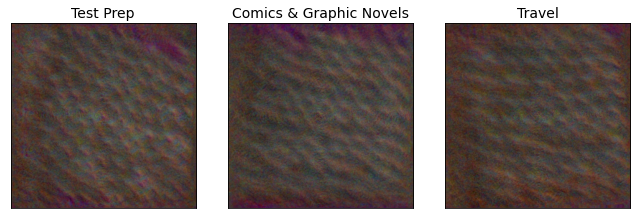

In [4]:
# Do 1000 iterations and Generate an optimizing
activations = activation_maximization(loss,
                                      seed_input=seed_input,
                                      steps=1000,
                                      callbacks=[ Print(interval=25)])
images = [activation.astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Data/Outputs/visualize-dense-layer')
plt.show()

In [6]:
plt.imsave('/content/drive/My Drive/Data/Outputs/test_prep.png', images[0])
plt.imsave('/content/drive/My Drive/Data/Outputs/comics.png', images[1])
plt.imsave('/content/drive/My Drive/Data/Outputs/travel.png', images[2])